## Machine learning on vpn non-vpn iscx 2016 dataset
We want to cpm[rae the time and accuracy of the classification against the FlowPic way.
We working on the same csv files that we created from the the FlowPic images.
This work was according to:
https://www.kaggle.com/code/guillaumefraysse/ucdavis-quic-data-exploration/notebook  
He wokred with Quic-text dataset. 
We got this work from Tal Shapira one of the FlowPic inventors 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from datetime import timedelta
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset 
df_chat = pd.read_csv('combined_chat_dataset.csv')
df_file = pd.read_csv('combined_file_dataset.csv')
df_voip = pd.read_csv('combined_voip_dataset.csv')
df_video = pd.read_csv('combined_video_dataset.csv')

In [3]:
df_chat.shape, df_file.shape, df_voip.shape ,df_video.shape

((7858, 9), (7113896, 9), (4423602, 9), (3697029, 9))

In [4]:
# Combining all DataFrames vertically
df_combined = pd.concat([df_chat, df_file, df_voip, df_video], 
                       axis=0,  # 0 means vertical stacking
                       ignore_index=True)  # Reset the index to avoid duplicates

In [5]:
df_combined.shape

(15242385, 9)

In [6]:
# View row at index 5 (6th row since indexing starts at 0)
# Checking that the combinations was fine, we have the changes between 'chat' and 'file'
df_combined.iloc[7857]

Timestamp          1432574590.677275
SourceIP              131.202.240.45
SourcePort                       161
DestinationIP        131.202.240.242
DestinationPort                56587
Protocol                         UDP
Size                             121
RelativeTime              930.057473
Attribution                     chat
Name: 7857, dtype: object

In [7]:
# View row at index 5 (6th row since indexing starts at 0)
df_combined.iloc[7858]

Timestamp          1430491037.334412
SourceIP              131.202.240.87
SourcePort                      4495
DestinationIP        131.202.240.242
DestinationPort                50602
Protocol                         TCP
Size                             462
RelativeTime                     0.0
Attribution                     file
Name: 7858, dtype: object

In [8]:
# Further we'll check also working also on balanced dataset, so we're taking samples numbers from the minimum of the dataset

min_size = min(df_chat.shape[0], df_file.shape[0], df_voip.shape[0], df_video.shape[0])

# Create balanced samples
df_chat_balanced = df_chat.sample(n=min_size, random_state=42)
df_file_balanced = df_file.sample(n=min_size, random_state=42)
df_voip_balanced = df_voip.sample(n=min_size, random_state=42)
df_video_balanced = df_video.sample(n=min_size, random_state=42)

# Combine the balanced datasets
df_combined_balanced = pd.concat([
    df_chat_balanced,
    df_file_balanced,
    df_voip_balanced,
    df_video_balanced
], axis=0, ignore_index=True)

# Verify the shapes
print("Original shapes:")
print(f"Chat: {df_chat.shape}")
print(f"File: {df_file.shape}")
print(f"VoIP: {df_voip.shape}")
print(f"Video: {df_video.shape}")

print("\nBalanced shapes:")
print(f"Chat: {df_chat_balanced.shape}")
print(f"File: {df_file_balanced.shape}")
print(f"VoIP: {df_voip_balanced.shape}")
print(f"Video: {df_video_balanced.shape}")
print(f"Combined balanced: {df_combined_balanced.shape}")

Original shapes:
Chat: (7858, 9)
File: (7113896, 9)
VoIP: (4423602, 9)
Video: (3697029, 9)

Balanced shapes:
Chat: (7858, 9)
File: (7858, 9)
VoIP: (7858, 9)
Video: (7858, 9)
Combined balanced: (31432, 9)


In [9]:
del df_chat, df_file, df_voip, df_video # For freeing space in the RAM

In [47]:
del df_chat_balanced, df_file_balanced, df_voip_balanced, df_video_balanced  # For freeing space in the RAM

In [10]:
df_combined.head()

,Timestamp,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Size,RelativeTime,Attribution
0,1.430326e+09,131.202.240.242,51434,131.202.240.45,161,UDP,107,0.000000,chat
1,1.430326e+09,131.202.240.242,51434,131.202.240.45,161,UDP,107,0.000079,chat
2,1.430326e+09,131.202.240.242,51434,131.202.240.45,161,UDP,107,0.000127,chat
3,1.430326e+09,131.202.240.242,51434,131.202.240.45,161,UDP,107,0.000187,chat
4,1.430326e+09,131.202.240.45,161,131.202.240.242,51434,UDP,122,0.008464,chat


# Unbalanced dataset, the dataset as is

In [11]:
df_combined.drop(columns=['Timestamp','SourceIP','SourcePort'], axis = 1, inplace = True) # leaving features like in thwe work we've seen plus more features

In [12]:
df_combined.shape

(15242385, 6)

In [13]:
# Create LabelEncoder objects
le_ip = LabelEncoder()
le_protocol = LabelEncoder()
le_Attribution = LabelEncoder()

# Fit and transform the columns
df_combined['DestinationIp_encoded'] = le_ip.fit_transform(df_combined['DestinationIP'])
df_combined['Protocol_encoded'] = le_protocol.fit_transform(df_combined['Protocol'])
df_combined['Attribution_encoded'] = le_Attribution.fit_transform(df_combined['Attribution'])

# If you want to keep the original columns:
# The encoded columns will be new columns alongside the original ones

# If you want to replace the original columns:
df_combined['DestinationIP'] = df_combined['DestinationIp_encoded']
df_combined['Protocol'] = df_combined['Protocol_encoded']
df_combined['Attribution'] = df_combined['Attribution_encoded']

# Save the mappings for each encoder
ip_classes = le_ip.classes_
protocol_classes = le_protocol.classes_
attribution_classes = le_Attribution.classes_

# Create dictionaries for mappings (optional but useful)
ip_mapping = dict(zip(le_ip.classes_, le_ip.transform(le_ip.classes_)))
protocol_mapping = dict(zip(le_protocol.classes_, le_protocol.transform(le_protocol.classes_)))
attribution_mapping = dict(zip(le_Attribution.classes_, le_Attribution.transform(le_Attribution.classes_)))

# Print mappings to verify
print("IP Mapping:", ip_mapping)
print("Protocol Mapping:", protocol_mapping)
print("Attribution Mapping:", attribution_mapping)

df_combined = df_combined.drop(['DestinationIp_encoded', 'Protocol_encoded', 'Attribution_encoded'], axis=1)

# # To save the mapping for future reference
# destination_ip_mapping = dict(zip(le_ip.classes_, le_ip.transform(le_ip.classes_)))
# protocol_mapping = dict(zip(le_protocol.classes_, le_protocol.transform(le_protocol.classes_)))

# # Print mappings to see the encoding
# print("DestinationIp mapping:", destination_ip_mapping)
# print("Protocol mapping:", protocol_mapping)

# # Convert back to original values
# original_ip = le_ip.inverse_transform(df_combined['DestinationIp'])
# original_protocol = le_protocol.inverse_transform(df_combined['Protocol'])

IP Mapping: {'10.0.2.15': 0, '108.175.39.202': 1, '108.175.42.181': 2, '108.175.43.146': 3, '108.175.43.161': 4, '131.202.240.101': 5, '131.202.240.113': 6, '131.202.240.150': 7, '131.202.240.242': 8, '131.202.240.45': 9, '131.202.240.65': 10, '131.202.240.72': 11, '131.202.240.86': 12, '131.202.240.87': 13, '173.194.207.127': 14, '173.194.76.127': 15, '173.252.100.27': 16, '178.237.19.103': 17, '178.237.19.227': 18, '178.237.19.228': 19, '178.237.24.202': 20, '199.212.24.172': 21, '199.212.24.173': 22, '209.148.205.35': 23, '209.148.205.41': 24, '64.12.104.73': 25, '64.12.104.85': 26, '64.12.24.167': 27, '74.125.226.160': 28, '74.125.226.161': 29, '74.125.226.162': 30, '74.125.226.164': 31, '74.125.226.167': 32, '74.125.226.172': 33, '74.125.226.174': 34, '74.125.226.181': 35}
Protocol Mapping: {'TCP': 0, 'UDP': 1}
Attribution Mapping: {'chat': 0, 'file': 1, 'video': 2, 'voip': 3}


In [14]:
# Find columns with non-numeric data in X_test
non_numeric_columns = df_combined.select_dtypes(include=['object', 'string']).columns

# Print the non-numeric columns
print("Non-numeric columns in df_combined")
print(non_numeric_columns)

Non-numeric columns in df_combined
Index([], dtype='object')


In [15]:
# Suffeling the data
df_combined = shuffle(df_combined, random_state=42)

In [16]:
# Preparing for the splitting
X = df_combined.drop('Attribution', axis = 1)
y = df_combined['Attribution']

In [17]:
X.shape, y.shape

((15242385, 5), (15242385,))

In [18]:
# Shuffle and split the data
# First split: 80% train+val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (from the remaining 80%)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

# Print shapes to verify
print(f'Training set shape: {X_train.shape} {y_train.shape}')

Training set shape: (9145431, 5) (9145431,)


In [19]:
print(f'Training set shape: {X_val.shape} {y_val.shape}')
print(f'Training set shape: {X_test.shape} {y_test.shape}')

Training set shape: (3048477, 5) (3048477,)
Training set shape: (3048477, 5) (3048477,)


## Test and train the unbalanced dataset 

In [19]:
# Scaling - option to add here standart scalar 

### Training the model
We're using RandomForest and ExtraTree classifiers.
we can always play with the parameters and add **GridSearch** for the best parameters in each classifier.
We can add also a loop to check the best random seed (but it won't be quick).

In [20]:
start_time = time.time() # checking training time

rf = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators = 100) 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

training_time = time.time() - start_time

accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"RadomForest Accuracy on Test Dataset: {accuracy_rf:.4f}")
print("Classification Report (RadomForest):\n", classification_report(y_val, y_pred_rf))
print(f'Total training time: {timedelta(seconds=training_time)}')

RadomForest Accuracy on Test Dataset: 0.9839
Classification Report (RadomForest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1565
           1       1.00      1.00      1.00   1420757
           2       0.97      0.96      0.97    740386
           3       0.97      0.97      0.97    885769

    accuracy                           0.98   3048477
   macro avg       0.98      0.98      0.98   3048477
weighted avg       0.98      0.98      0.98   3048477

Total training time: 0:09:28.784487


<Figure size 1000x800 with 0 Axes>

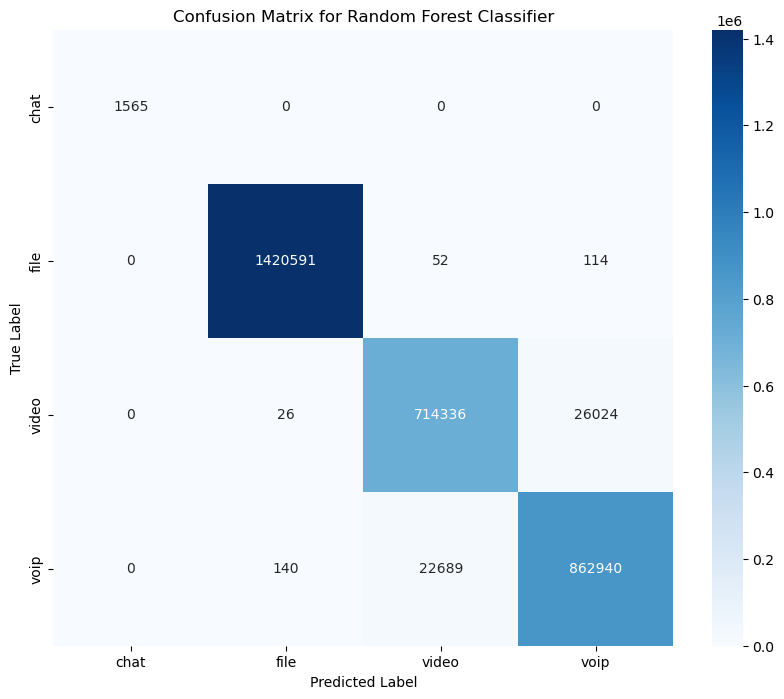

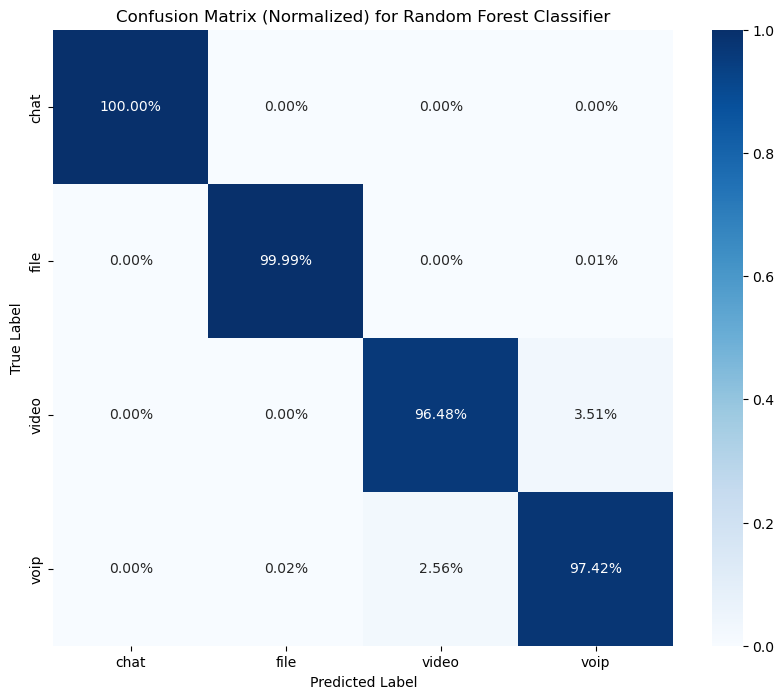

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred_rf)

class_names = le_Attribution.classes_

# Get back original class names
# original_classes = le_Attribution.inverse_transform(np.unique(y_val))

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
# Using ExtraTree classifier
st_time = time.time()

et = ExtraTreesClassifier(random_state=42, n_jobs=-1, n_estimators=100)
et.fit(X_train, y_train)

extree_time = time.time() - st_time

y_pred_et = et.predict(X_val)
accuracy_et = accuracy_score(y_val, y_pred_et)
print(f"ExtraTrees Accuracy on Test Dataset: {accuracy_et:.4f}")
print("Classification Report (ExtraTrees):\n", classification_report(y_val, y_pred_et))
print(f'Total training time: {timedelta(seconds=extree_time)}')

ExtraTrees Accuracy on Test Dataset: 0.9840
Classification Report (ExtraTrees):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1565
           1       1.00      1.00      1.00   1420757
           2       0.97      0.97      0.97    740386
           3       0.97      0.97      0.97    885769

    accuracy                           0.98   3048477
   macro avg       0.98      0.98      0.98   3048477
weighted avg       0.98      0.98      0.98   3048477

Total training time: 0:03:41.521981


<Figure size 1000x800 with 0 Axes>

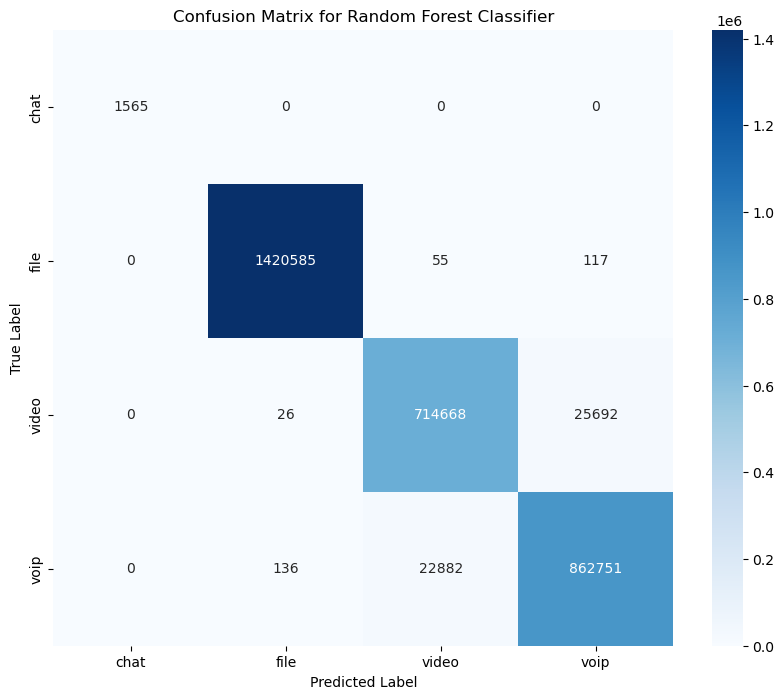

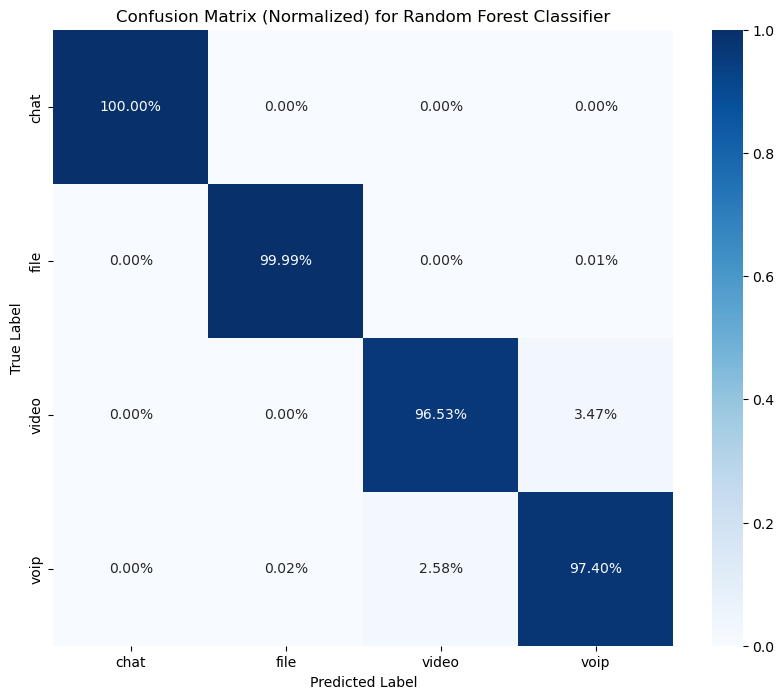

In [29]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred_et)

# Now when you need the class names for confusion matrix:
class_names = le_Attribution.classes_  # This will give you the original class names

# Get back original class names
# original_classes = le_Attribution.inverse_transform(np.unique(y_val))

# xticklabels=attribution_classes,  # Use saved classes
            # yticklabels=attribution_classes

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Saving the model
We can save here the trained model and load it to do only the infrence.
To do this, we need forst to save separately the X_test or any dataset that we're using for the infrence.
Then to save each model, the label encoders, the training models, if we have scaled the dataset so also this, etc.. 

In [30]:
# # Saving the model
# joblib.dump(le_ip, "le_ip.pkl")
# joblib.dump(le_protocol, "le_protocol.pkl")
# joblib.dump(le_Attribution, "le_Attribution.pkl")

# # The trained classifiers
# joblib.dump(rf, "rf_classifier.pkl")
# joblib.dump(et, "et_classifier.pkl")

### Infrence

In [31]:
infrence_start_time = time.time()
y_test_pred = rf.predict(X_test)
infrence_time = time.time() - infrence_start_time

accuracy_inf = accuracy_score(y_test, y_test_pred)
print(f"RadomForest Accuracy on Test Dataset: {accuracy_inf:.4f}")
print("Classification Report (RadomForest):\n", classification_report(y_test, y_test_pred))
print(f'Total training time: {timedelta(seconds=infrence_time)}')

RadomForest Accuracy on Test Dataset: 0.9841
Classification Report (RadomForest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1572
           1       1.00      1.00      1.00   1422504
           2       0.97      0.97      0.97    739488
           3       0.97      0.97      0.97    884913

    accuracy                           0.98   3048477
   macro avg       0.99      0.98      0.98   3048477
weighted avg       0.98      0.98      0.98   3048477

Total training time: 0:00:12.272871


<Figure size 1000x800 with 0 Axes>

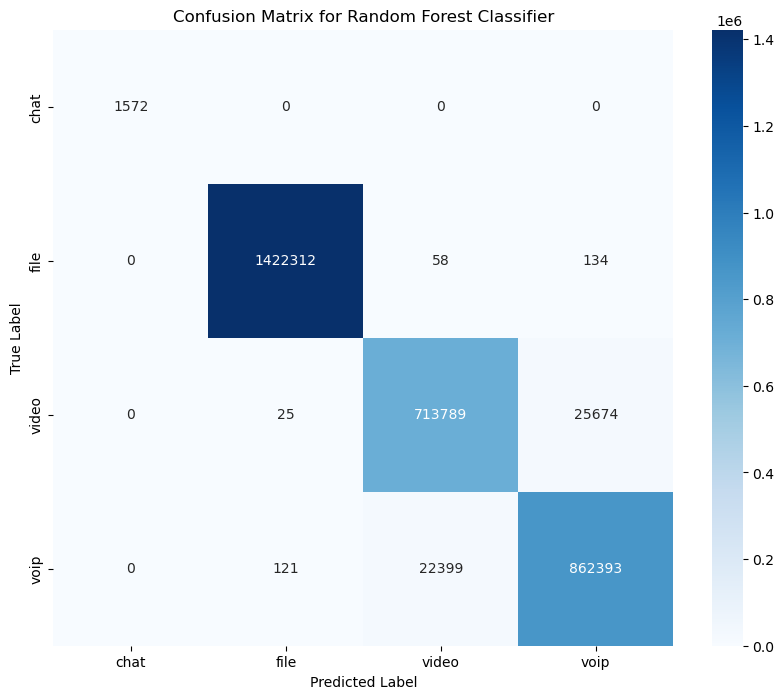

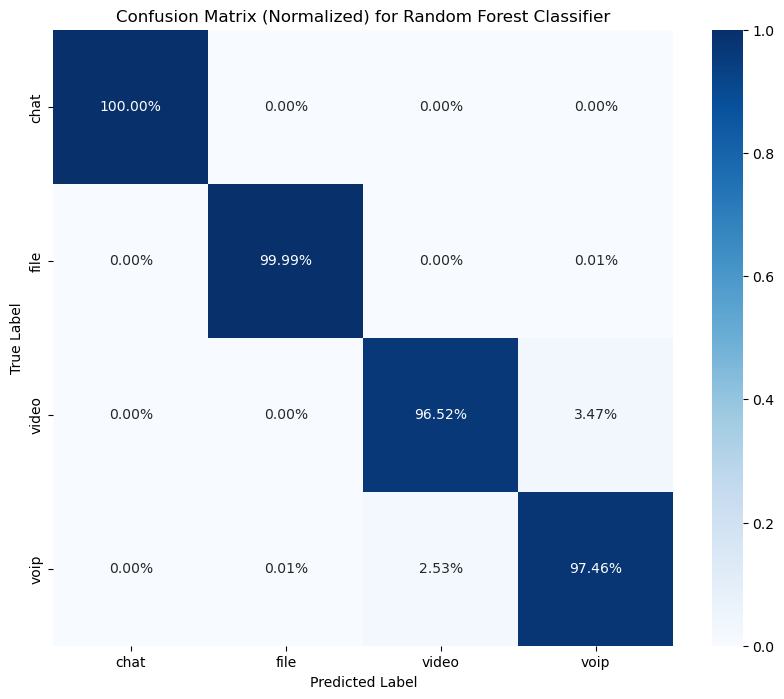

In [33]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

class_names = le_Attribution.classes_

# Get back original class names
# original_classes = le_Attribution.inverse_transform(np.unique(y_val))

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()# Confustion matrix

# Balanced dataset
We'll take samples the same from each class, like the smallest of all classes (the chat)

In [40]:
df_combined_balanced.head()

,DestinationIP,DestinationPort,Protocol,Size,RelativeTime,Attribution,DestinationIp_encoded,Protocol_encoded,Attribution_encoded
0,6,51434,1,94,314.755549,0,6,1,0
1,7,161,1,146,2.919208,0,7,1,0
2,6,51434,1,146,464.831845,0,6,1,0
3,6,51434,1,92,597.205327,0,6,1,0
4,7,161,1,145,544.757859,0,7,1,0


In [41]:
# Fit and transform the columns
df_combined_balanced['DestinationIp_encoded'] = le_ip.fit_transform(df_combined_balanced['DestinationIP'])
df_combined_balanced['Protocol_encoded'] = le_protocol.fit_transform(df_combined_balanced['Protocol'])
df_combined_balanced['Attribution_encoded'] = le_Attribution.fit_transform(df_combined_balanced['Attribution'])

# If you want to keep the original columns:
# The encoded columns will be new columns alongside the original ones

# If you want to replace the original columns:
df_combined_balanced['DestinationIP'] = df_combined_balanced['DestinationIp_encoded']
df_combined_balanced['Protocol'] = df_combined_balanced['Protocol_encoded']
df_combined_balanced['Attribution'] = df_combined_balanced['Attribution_encoded']

df_combined_balanced = df_combined_balanced.drop(['DestinationIp_encoded', 'Protocol_encoded', 'Attribution_encoded'], axis=1)

In [42]:
df_combined_balanced.drop(columns=['Timestamp','SourceIP','SourcePort'], axis = 1, inplace = True) # leaving features like in thwe work we've seen plus more features

KeyError: "['Timestamp', 'SourceIP', 'SourcePort'] not found in axis"

In [44]:
X_balanced = df_combined_balanced.drop('Attribution', axis = 1)
y_balanced = df_combined_balanced['Attribution']

In [45]:
# Shuffle and split the data
# First split: 80% train+val, 20% test
X_trainval_bal, X_test_bal, y_trainval_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (from the remaining 80%)
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(X_trainval_bal, y_trainval_bal, test_size=0.25, random_state=42)

# Print shapes to verify
print(f'Training set shape: {X_train_bal.shape} {y_train_bal.shape}')

Training set shape: (18858, 5) (18858,)


In [46]:
X_train_bal.shape, X_val_bal.shape, X_test_bal.shape, y_train_bal.shape, y_val_bal.shape, y_test_bal.shape

((18858, 5), (6287, 5), (6287, 5), (18858,), (6287,), (6287,))

In [48]:
start_time_bal = time.time()

rf_bal = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators = 100) # or seed = 9
rf_bal.fit(X_train_bal, y_train_bal)
y_pred_rf_bal = rf_bal.predict(X_val_bal)

training_time_bal = time.time() - start_time_bal

accuracy_rf = accuracy_score(y_val_bal, y_pred_rf_bal)
print(f"RadomForest Accuracy on Test Dataset: {accuracy_rf:.4f}")
print("Classification Report (RadomForest):\n", classification_report(y_val_bal, y_pred_rf_bal))
print(f'Total training time: {timedelta(seconds=training_time_bal)}')

RadomForest Accuracy on Test Dataset: 0.9811
Classification Report (RadomForest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00      1520
           2       0.96      0.97      0.96      1650
           3       0.96      0.96      0.96      1561

    accuracy                           0.98      6287
   macro avg       0.98      0.98      0.98      6287
weighted avg       0.98      0.98      0.98      6287

Total training time: 0:00:00.524873


<Figure size 1000x800 with 0 Axes>

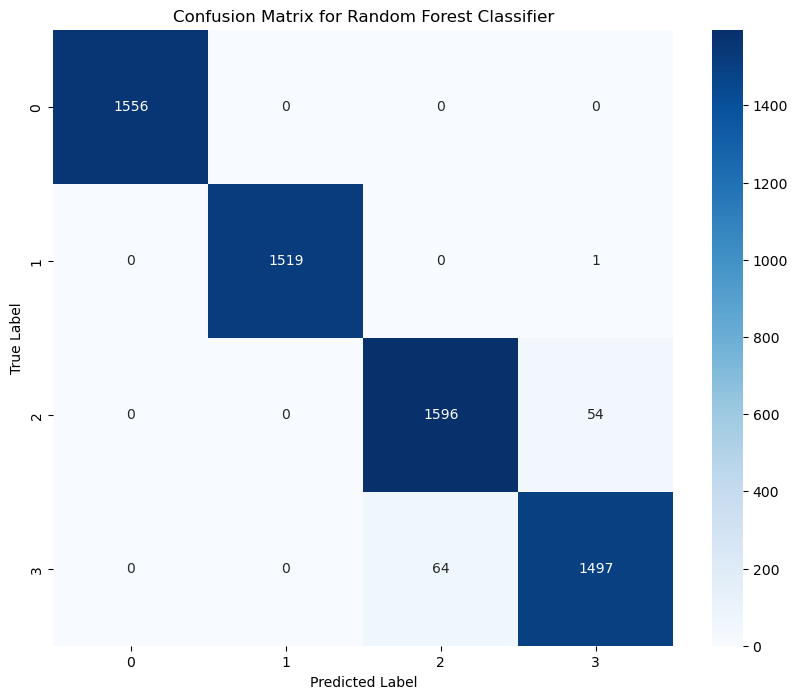

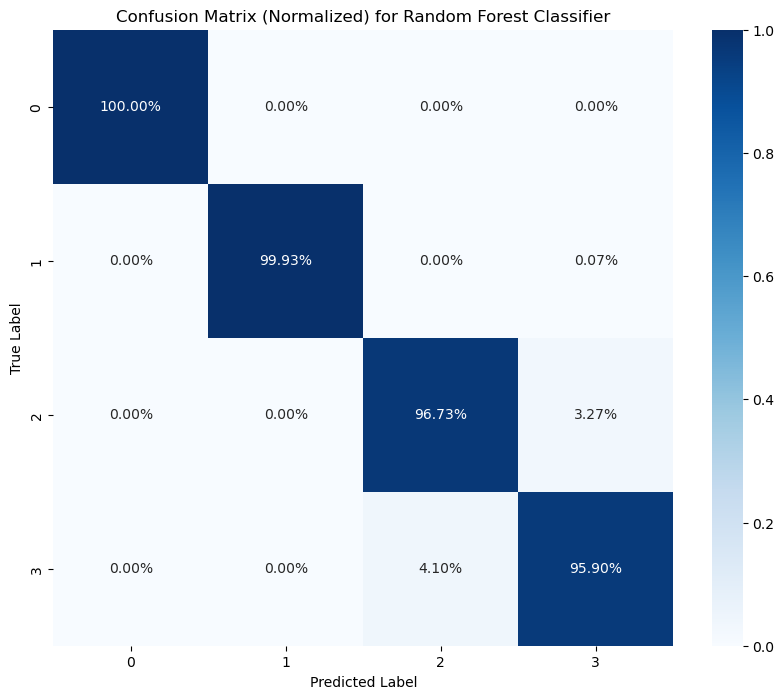

In [49]:
# Calculate confusion matrix
cm = confusion_matrix(y_val_bal, y_pred_rf_bal)

class_names = le_Attribution.classes_

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [50]:
infrence_start_time_bal = time.time()
y_test_pred_bal = rf.predict(X_test_bal)
infrence_time_bal = time.time() - infrence_start_time_bal

accuracy_inf_bal = accuracy_score(y_test_bal, y_test_pred_bal)
print(f"RadomForest Accuracy on Test Dataset: {accuracy_inf:.4f}")
print("Classification Report (RadomForest):\n", classification_report(y_test_bal, y_test_pred_bal))
print(f'Total training time: {timedelta(seconds=infrence_time_bal)}')

RadomForest Accuracy on Test Dataset: 0.9841
Classification Report (RadomForest):
               precision    recall  f1-score   support

           0       0.99      0.55      0.71      1574
           1       0.82      1.00      0.90      1653
           2       0.98      0.61      0.75      1571
           3       0.60      0.98      0.75      1489

    accuracy                           0.78      6287
   macro avg       0.85      0.78      0.78      6287
weighted avg       0.85      0.78      0.78      6287

Total training time: 0:00:00.177372


<Figure size 1000x800 with 0 Axes>

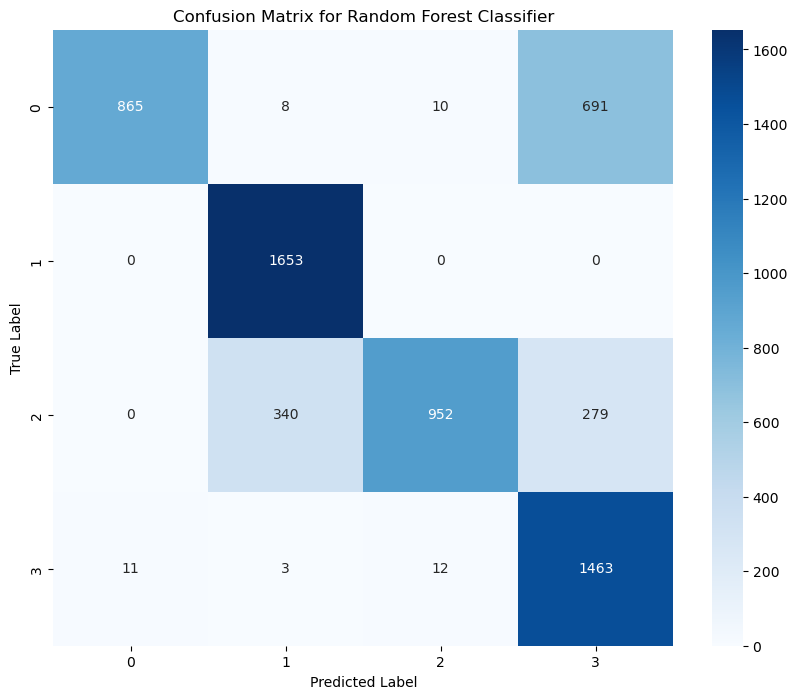

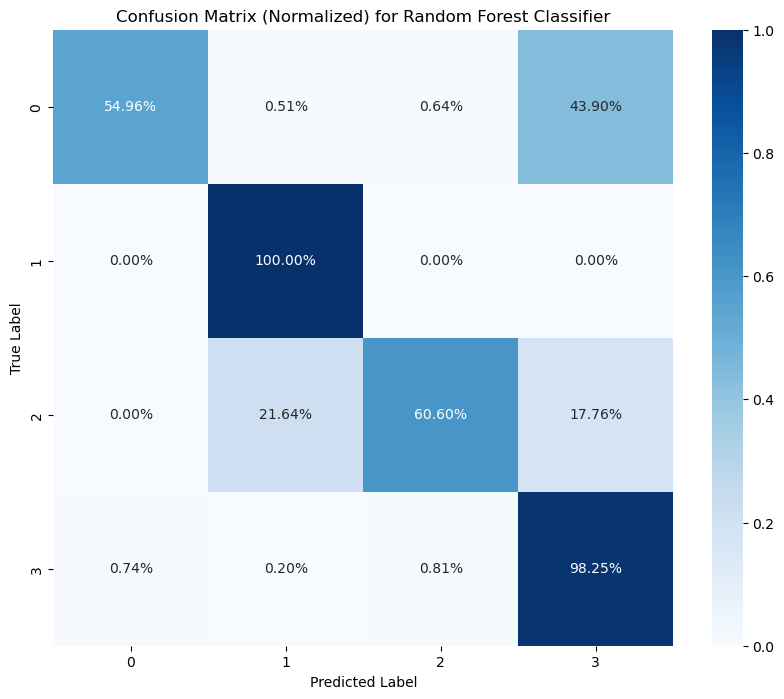

In [51]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_bal, y_test_pred_bal)

class_names = le_Attribution.classes_

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [52]:
# Using ExtraTree classifier
st_time_bal = time.time()

et_bal = ExtraTreesClassifier(random_state=42, n_jobs=-1, n_estimators=100)
et_bal.fit(X_train_bal, y_train_bal)

extree_time_bal = time.time() - st_time_bal

y_pred_et_bal = et.predict(X_val_bal)
accuracy_et_bal = accuracy_score(y_val_bal, y_pred_et_bal)
print(f"ExtraTrees Accuracy on Test Dataset: {accuracy_et_bal:.4f}")
print("Classification Report (ExtraTrees):\n", classification_report(y_val_bal, y_pred_et_bal))
print(f'Total training time: {timedelta(seconds=extree_time_bal)}')

ExtraTrees Accuracy on Test Dataset: 0.7570
Classification Report (ExtraTrees):
               precision    recall  f1-score   support

           0       0.96      0.55      0.70      1556
           1       0.82      0.86      0.84      1520
           2       0.82      0.65      0.73      1650
           3       0.61      0.97      0.75      1561

    accuracy                           0.76      6287
   macro avg       0.80      0.76      0.75      6287
weighted avg       0.80      0.76      0.75      6287

Total training time: 0:00:00.222961


<Figure size 1000x800 with 0 Axes>

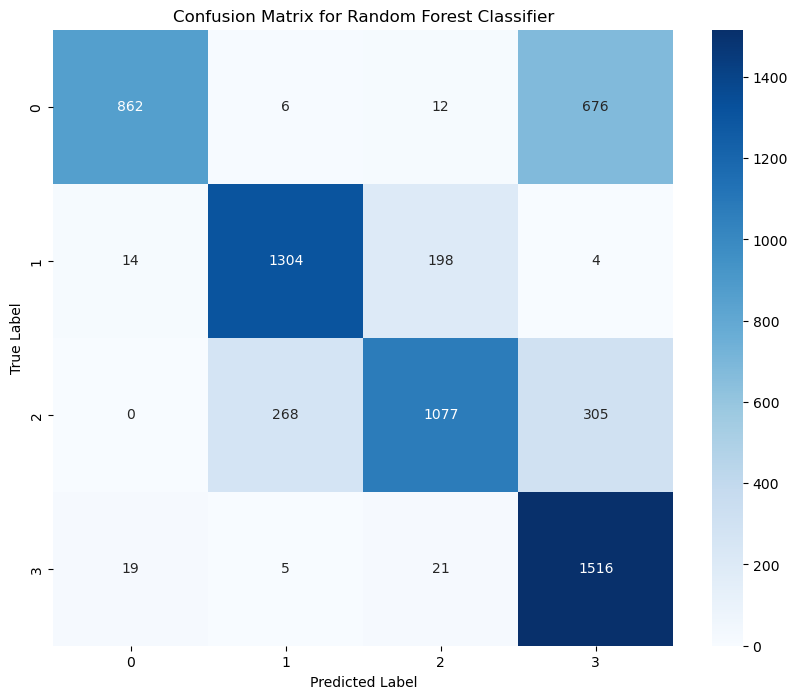

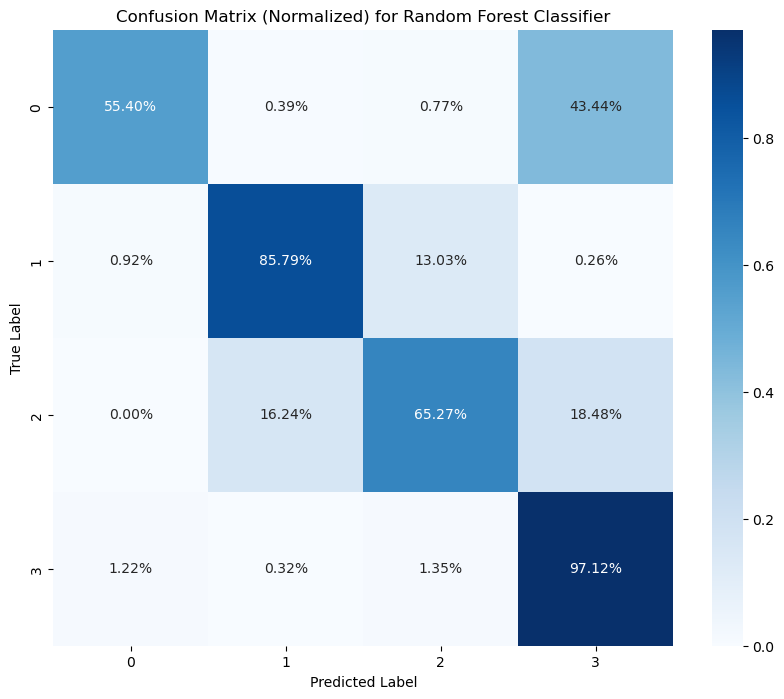

In [53]:
# Calculate confusion matrix
cm = confusion_matrix(y_val_bal, y_pred_et_bal)

class_names = le_Attribution.classes_

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [55]:
# BaggingClassifier with DecisionTree as base estimator

start_bag_bal = time.time()

bagging_clf_bal = BaggingClassifier(random_state=42, n_estimators=150) #,max_samples=0.75, max_features=0.55)

bagging_clf_bal.fit(X_train_bal, y_train_bal)

bag_time_bal = time.time() - start_bag_bal

y_pred_bagging_bal = bagging_clf_bal.predict(X_val_bal)
accuracy_bagging_bal = accuracy_score(y_val_bal, y_pred_bagging_bal)
print(f"BaggingClassifier Accuracy on Test Dataset: {accuracy_bagging_bal:.4f}")
print("Classification Report (BaggingClassifier):\n", classification_report(y_val_bal, y_pred_bagging_bal))

print(f'Total training time: {timedelta(seconds=bag_time_bal)}')

BaggingClassifier Accuracy on Test Dataset: 0.9790
Classification Report (BaggingClassifier):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00      1520
           2       0.96      0.96      0.96      1650
           3       0.96      0.96      0.96      1561

    accuracy                           0.98      6287
   macro avg       0.98      0.98      0.98      6287
weighted avg       0.98      0.98      0.98      6287

Total training time: 0:00:03.479643


<Figure size 1000x800 with 0 Axes>

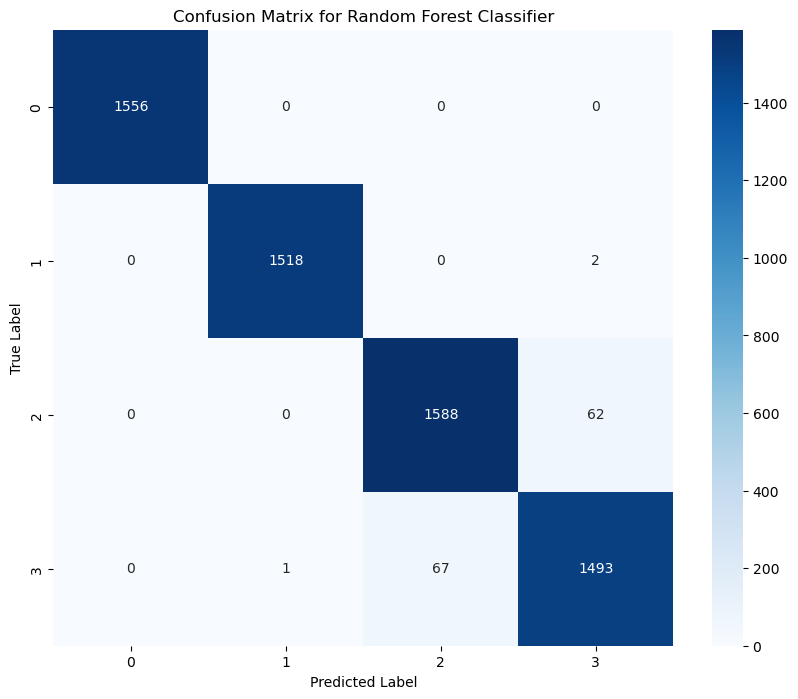

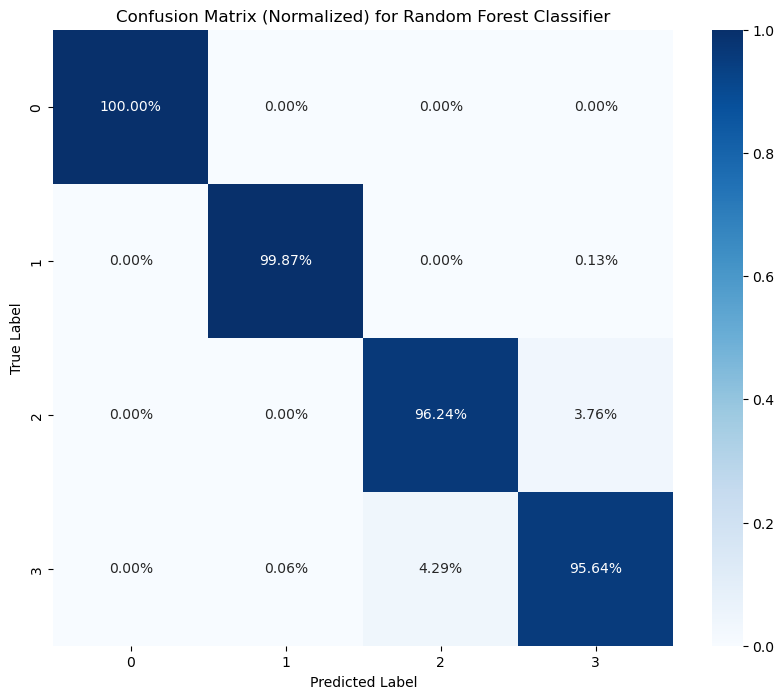

In [56]:
# Calculate confusion matrix
cm = confusion_matrix(y_val_bal, y_pred_bagging_bal)

class_names = le_Attribution.classes_

# Create a figure and axis
plt.figure(figsize=(10, 8))

# If you want more details with class names (if you have them):
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# For better readability with percentages:
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()